In [1]:
#%%
import numpy
import librosa
import tensorflow as tf
import ddsp.training
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from livelossplot import PlotLosses

#%%

# define some utilis
def play(audio):
  display(Audio(audio,rate=SAMPLE_RATE))

SR=16000
FRAME_RATE=250

CLIP_S=4
N_SAMPLES=16000*CLIP_S
SAMPLE_RATE=16000
SEED=1
FT_FRAME_RATE=250
N_FRAMES = CLIP_S*FT_FRAME_RATE

# load model

USE_NSYNTH=False
INSTRUMENT_FAMILY="all"

USE_FNR=False

USE_F0_CONFIDENCE=False

class CustomRnnFcDecoder(ddsp.training.nn.OutputSplitsLayer):
  """RNN and FC stacks for f0 and loudness.
  Allows for bidirectionality
  """

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               ch=512,
               layers_per_stack=3,
               input_keys=('ld_scaled', 'f0_scaled','z'),
               output_splits=(('amps', 1), ('harmonic_distribution', 40)),
               bidir=True,
               **kwargs):
    super().__init__(
        input_keys=input_keys, output_splits=output_splits, **kwargs)
    stack = lambda: ddsp.training.nn.FcStack(ch, layers_per_stack)
    
    # z should be considered as input
    self.input_stacks = [stack() for k in self.input_keys]
    
    self.rnn = ddsp.training.nn.Rnn(rnn_channels, rnn_type,bidir=bidir)
    self.out_stack = stack()

  def compute_output(self, *inputs):
    # Initial processing.
        
    inputs = [stack(x) for stack, x in zip(self.input_stacks, inputs)]

    # Run an RNN over the latents.
    x = tf.concat(inputs, axis=-1)
    x = self.rnn(x)
    x = tf.concat(inputs + [x], axis=-1)

    # Final processing.
    return self.out_stack(x)
 
class MultiInstrumentAutoencoder(ddsp.training.models.autoencoder.Autoencoder):
    def __init__(self,
               preprocessor=None,
               encoder=None,
               decoder=None,
               processor_group=None,
               losses=None,
               n_instruments=None,
               instrument_weight_metadata={},
               **kwargs):
        super().__init__(preprocessor,encoder,decoder,processor_group,losses,**kwargs)
        
        
        self.n_instruments=n_instruments
        self.instrument_weight_metadata=instrument_weight_metadata
        self.initialize_instrument_weights()
    
    def initialize_instrument_weights(self):
        self.instrument_weights={}
        for weight_name,weight_metadata in self.instrument_weight_metadata.items():
            self.instrument_weights[weight_name]=tf.Variable(weight_metadata["initializer"](self.n_instruments))
          
    def call(self, batch, train_shared):
        if self.encoder is not None:
            self.encoder.trainable=train_shared
        if self.decoder is not None:
            self.decoder.trainable=train_shared

        for weight_name,weights in self.instrument_weights.items():
            batch[weight_name]=tf.gather(weights,batch["instrument_idx"])
            if "processing" in self.instrument_weight_metadata[weight_name]:
                batch[weight_name]=self.instrument_weight_metadata[weight_name]["processing"](batch[weight_name])
        
        # this should go in a preprocessor but I'm too lazy to write a custom preprocessor
        batch["f0_confidence"]=batch["f0_confidence"][...,None]
        
        return super().call(batch,training=False)

from typing import Dict, Text

class Gain(ddsp.processors.Processor):
    def __init__(self, name: Text = 'gain'):
        super().__init__(name=name)
    
    def get_signal(self, signal: tf.Tensor,
                 gain_scaled: tf.Tensor) -> tf.Tensor:
        return gain_scaled * signal
    
    def get_controls(self,signal: tf.Tensor,
                 gain: tf.Tensor) -> tf.Tensor:
        return {"signal":signal,"gain_scaled":tf.nn.relu(gain)}
    

if USE_FNR==True:
    ## FN - REVERB MODEL

    # define model

    N_NOISE_MAGNITUDES=64
    N_HARMONICS=64
    N_INSTRUMENTS=1050

    EARLY_REFLECTIONS_S=0.1
    EARLY_REFLECTIONS_IR_SIZE=int(EARLY_REFLECTIONS_S*SAMPLE_RATE)

    BIDIRECTIONAL=False
    Z_SIZE=512


    IR_DURATION=1
    IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
    N_FNR_MAGNITUDES=64
    FNR_FRAMERATE=500




    preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

    decoder = CustomRnnFcDecoder(
                   rnn_channels=512,
                   rnn_type='gru',
                   ch=512,
                   layers_per_stack=3,
                   input_keys=("ld_scaled", 'f0_scaled','z',) if not USE_F0_CONFIDENCE else ("ld_scaled", 'f0_scaled','f0_confidence','z'),
                   output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
                   bidir=BIDIRECTIONAL
                   )

    harmonic = ddsp.synths.Harmonic(
        n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

    fn = ddsp.synths.FilteredNoise(
        n_samples=N_SAMPLES, window_size=0, initial_bias=-3.0, name='fn')

    late_reverb = ddsp.effects.FilteredNoiseReverb(name="late_reverb",initial_bias=-3,reverb_length=IR_SIZE,n_frames=FNR_FRAMERATE,n_filter_banks=N_FNR_MAGNITUDES,add_dry=False)

    early_reflections = ddsp.effects.Reverb(name="early_reflections",reverb_length=EARLY_REFLECTIONS_IR_SIZE,add_dry=False, trainable=False)

    harmonic_plus_fn= ddsp.processors.Add(name='harmonic+fn')
    er_plus_lr=ddsp.processors.Add(name='er+lr')
    wet_gain_plus_dry_gain = ddsp.processors.Add(name='wet_gain+dry_gain')

    dry_gain = Gain(name='dry_gain')
    lr_gain = Gain(name='lr_gain')

    dag = [
      (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
      (fn, ['magnitudes']),
      (harmonic_plus_fn, ['harmonic/signal', 'fn/signal']),
      (late_reverb, ["harmonic+fn/signal","fnr_magnitudes"]),
      (early_reflections, ["harmonic+fn/signal","early_reflections_ir"]),
      (lr_gain,["late_reverb/signal","lr_gain"]),
      (er_plus_lr,["lr_gain/signal","early_reflections/signal"]),
      (dry_gain,["harmonic+fn/signal","dry_gain"]),
      (wet_gain_plus_dry_gain,["er+lr/signal","dry_gain/signal"])
    ]

    processor_group=ddsp.processors.ProcessorGroup(dag=dag)

    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                                  mag_weight=1.0,
                                                  logmag_weight=1.0)

    instrument_weight_metadata = {
        "z":
            {
            "initializer":lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
            "processing":lambda batched_feature: tf.tanh(tf.tile(batched_feature,[1,FT_FRAME_RATE*CLIP_S,1]))
            },
        "fnr_magnitudes": 
            {
            "initializer":lambda batch_size: tf.random.normal([batch_size,IR_DURATION*FNR_FRAMERATE,N_FNR_MAGNITUDES])
            }
            ,
        "early_reflections_ir":
            {
                "initializer":lambda batch_size: tf.zeros([batch_size,EARLY_REFLECTIONS_IR_SIZE]),
                "processing": lambda batched_feature: tf.sigmoid(batched_feature)
            }
            ,
            "dry_gain":
                {"initializer":lambda batch_size : tf.ones([batch_size,1])},
            "lr_gain":
                {"initializer":lambda batch_size : tf.ones([batch_size,1])}
    }

    ae = MultiInstrumentAutoencoder(
        preprocessor=preprocessor,
        decoder=decoder,
        processor_group=processor_group,
        n_instruments=N_INSTRUMENTS,
        instrument_weight_metadata=instrument_weight_metadata
    )
else:

    ## IR REVERB MODEL

    # define model

    N_NOISE_MAGNITUDES=64
    N_HARMONICS=64
    N_INSTRUMENTS=1050

    BIDIRECTIONAL=True
    Z_SIZE=512

    IR_DURATION=1
    IR_SIZE=int(SAMPLE_RATE*IR_DURATION)

    preprocessor=ddsp.training.preprocessing.F0LoudnessPreprocessor()

    decoder = CustomRnnFcDecoder(
                   rnn_channels=512,
                   rnn_type='gru',
                   ch=512,
                   layers_per_stack=3,
                   input_keys=("ld_scaled", 'f0_scaled','z',) if not USE_F0_CONFIDENCE else ("ld_scaled", 'f0_scaled','f0_confidence','z'),
                   output_splits=(('amps', 1), ('harmonic_distribution', N_HARMONICS),('magnitudes', N_NOISE_MAGNITUDES)),
                   bidir=BIDIRECTIONAL
                   )

    harmonic = ddsp.synths.Harmonic(
        n_samples=N_SAMPLES, sample_rate=SAMPLE_RATE, name='harmonic')

    fn = ddsp.synths.FilteredNoise(
        n_samples=N_SAMPLES, window_size=0, initial_bias=-3.0, name='fn')

    reverb = ddsp.effects.Reverb(name="reverb",reverb_length=IR_SIZE,add_dry=False, trainable=False)

    harmonic_plus_fn= ddsp.processors.Add(name='harmonic+fn')
    wet_gain_plus_dry_gain = ddsp.processors.Add(name='wet_gain+dry_gain')

    dry_gain = Gain(name='dry_gain')
    wet_gain = Gain(name='wet_gain')

    dag = [
      (harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
      (fn, ['magnitudes']),
      (harmonic_plus_fn, ['harmonic/signal', 'fn/signal']),
      (reverb, ["harmonic+fn/signal","ir"]),
      (wet_gain,["reverb/signal","wet_gain"]),
      (dry_gain,["harmonic+fn/signal","dry_gain"]),
      (wet_gain_plus_dry_gain,["wet_gain/signal","dry_gain/signal"])
    ]

    processor_group=ddsp.processors.ProcessorGroup(dag=dag)

    spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                                  mag_weight=1.0,
                                                  logmag_weight=1.0)

    instrument_weight_metadata = {
        "z":
            {
            "initializer":lambda batch_size: tf.random.normal([batch_size,1,Z_SIZE]),
            "processing":lambda batched_feature: tf.tanh(tf.tile(batched_feature,[1,FT_FRAME_RATE*CLIP_S,1]))
            },
            "ir":
            {
                "initializer":lambda batch_size: tf.zeros([batch_size,IR_SIZE])
            }
            ,
            "dry_gain":
                {"initializer":lambda batch_size : tf.math.sigmoid(tf.ones([batch_size,1]))},
            "wet_gain":
                {"initializer":lambda batch_size :  tf.math.sigmoid(tf.ones([batch_size,1]))}
    }

    ae = MultiInstrumentAutoencoder(
        preprocessor=preprocessor,
        decoder=decoder,
        processor_group=processor_group,
        n_instruments=N_INSTRUMENTS,
        instrument_weight_metadata=instrument_weight_metadata
    )




#%%



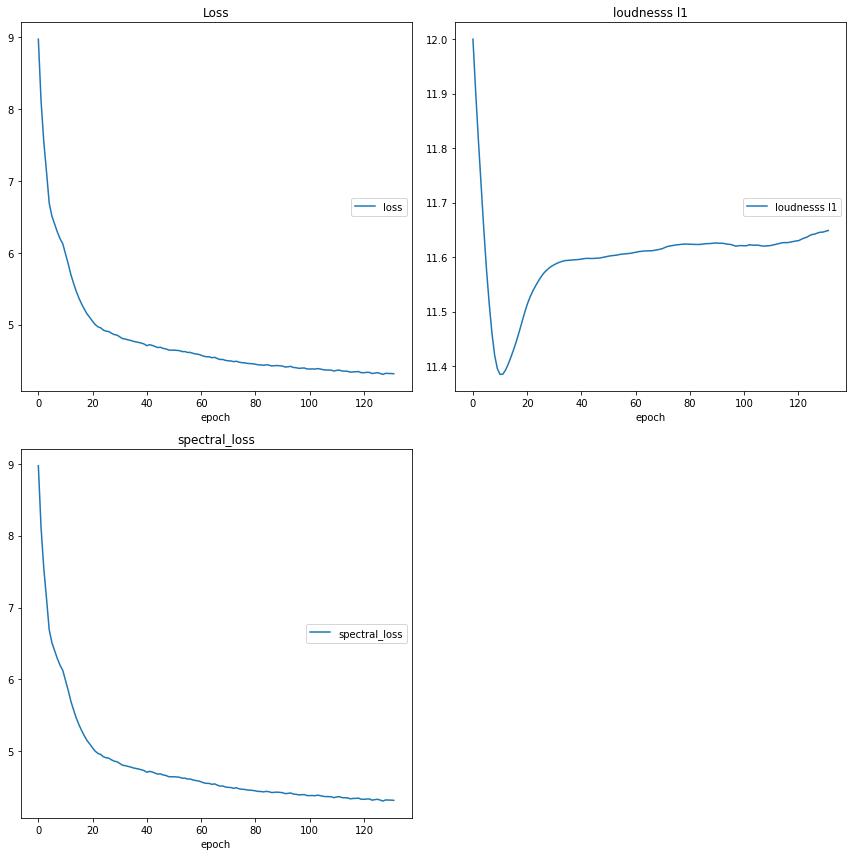

Loss
	loss             	 (min:    4.306, max:    8.973, cur:    4.316)
loudnesss l1
	loudnesss l1     	 (min:   11.385, max:   12.000, cur:   11.649)
spectral_loss
	spectral_loss    	 (min:    4.306, max:    8.973, cur:    4.316)
tf.Tensor(4.315798, shape=(), dtype=float32)


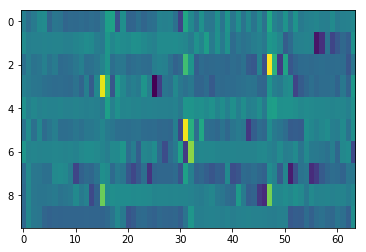

(10, 64)


KeyboardInterrupt: 

In [4]:
# TODO : ONSETS &. FRAMES, MAKE SURE Z, REVERB IS INITIALIZED PROPERLY

checkpoint_path=f"artefacts/dler_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}{'_fn' if USE_FNR else ''}_conv_family_{INSTRUMENT_FAMILY}{'_f0c' if USE_F0_CONFIDENCE else ''}"

print(checkpoint_path)
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass


# tensorflow does not allow me to load model unless this occurs
if not USE_FNR:
    TEST_IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
    ae.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,IR_SIZE])

ae.initialize_instrument_weights()


ae.load_weights(checkpoint_path)

# only support small ir in test phase
if not USE_FNR:
    TEST_IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
    # modify ir initializer
    ae.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,TEST_IR_SIZE])
    ae.instrument_weight_metadata["ir"]["processing"]=lambda batch: tf.math.tanh(tf.math.tanh(batch))
    #ae_test.instrument_weight_metadata["wet_gain"]["processing"]=lambda batch: 0*tf.math.tanh(batch)**3.0
    pass

ae.initialize_instrument_weights()


target,sr = librosa.load('artefacts/a.wav',sr=SR)

target = target[:N_SAMPLES]

N_PITCHES=10
MIN_PITCH=59+12

loudness = tf.Variable(-12.0*tf.ones((N_PITCHES,64)),dtype=tf.float32)
f0_hz= ddsp.core.midi_to_hz(tf.linspace(0,N_PITCHES-1,N_PITCHES)[...,None]+MIN_PITCH)
instrument_index = 10+tf.zeros((N_PITCHES),dtype=tf.int32)
f0_confidence = f0_hz*0+1


print(loudness.shape)
N_ITERATIONS=500

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

loss_fn=ddsp.losses.SpectralLoss(loss_type='L1',logmag_weight=1.0,mag_weight=1.0)

plotlosses = PlotLosses()

trainable_weights=[*ae.instrument_weights.values(),loudness]


for i in range(N_ITERATIONS):
    with tf.GradientTape() as tape:
        controls={
            "instrument_idx":instrument_index,
            "f0_hz":f0_hz,
            "loudness_db":ddsp.spectral_ops.amplitude_to_db(tf.nn.sigmoid(loudness),use_tf=True),
            "f0_confidence":f0_confidence}
        output=ae(controls,train_shared=True)
        
        print(controls["loudness_db"].shape)
        
        #audio = tf.reduce_sum(output["audio_synth"],axis=0)
        audio = tf.reduce_sum(output['harmonic+fn']["signal"],axis=0) 
        
        play(tf.reshape(output["audio_synth"],(-1)))
        
        
        sloss=loss_fn(audio,target)
        rloss=tf.reduce_mean(tf.abs(loudness))
        
        loss_value=sloss
        
        gradients = tape.gradient(loss_value,trainable_weights)

        optimizer.apply_gradients(zip(gradients,trainable_weights))

        plotlosses.update({'loss': loss_value,"spectral_loss":sloss,"loudnesss l1":rloss})
        plotlosses.send()
        print(loss_value)
        
        plt.imshow(controls["loudness_db"],aspect='auto')
        plt.show()
        
        if i%10==0:
            play(output["audio_synth"][0])
            play(audio)
            play(target)

                  
plt.imshow(loudness,aspect='auto')
plt.show()

play(output["audio_synth"][0])
play(audio)
play(target)

# %%

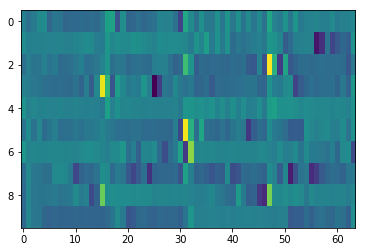

In [5]:
plt.imshow(controls["loudness_db"],aspect='auto')
plt.show()

play(tf.reshape(output["audio_synth"],(-1)))
play(tf.reshape(output['harmonic+fn']["signal"],(-1))) 
play(audio)
play(target)



In [ ]:
# TODO : ONSETS &. FRAMES, MAKE SURE Z, REVERB IS INITIALIZED PROPERLY

checkpoint_path=f"artefacts/dler_{'bidir' if BIDIRECTIONAL else 'unidir'}_z{Z_SIZE}{'_fn' if USE_FNR else ''}_conv_family_{INSTRUMENT_FAMILY}{'_f0c' if USE_F0_CONFIDENCE else ''}"

print(checkpoint_path)
try:
    print("loading checkpoint")
    ae.load_weights(checkpoint_path)
except:
    print("couldn't load checkpoint")
    pass


# tensorflow does not allow me to load model unless this occurs
if not USE_FNR:
    TEST_IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
    ae.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,IR_SIZE])

ae.initialize_instrument_weights()


ae.load_weights(checkpoint_path)

# only support small ir in test phase
if not USE_FNR:
    TEST_IR_SIZE=int(SAMPLE_RATE*IR_DURATION)
    # modify ir initializer
    ae.instrument_weight_metadata["ir"]["initializer"]=lambda batch_size: tf.zeros([batch_size,TEST_IR_SIZE])
    ae.instrument_weight_metadata["ir"]["processing"]=lambda batch: tf.math.tanh(tf.math.tanh(batch))
    #ae_test.instrument_weight_metadata["wet_gain"]["processing"]=lambda batch: 0*tf.math.tanh(batch)**3.0
    pass

ae.initialize_instrument_weights()


target,sr = librosa.load('artefacts/a.wav',sr=SR)

target = target[:N_SAMPLES]

N_PITCHES=10
MIN_PITCH=59+12

NF=1000
envelope = tf.Variable(tf.cast(tf.linspace(1,0,NF)[None,...],dtype=tf.float32))
onsets = tf.Variable(tf.random.normal((N_PITCHES,NF)),dtype=tf.float32)

f0_hz= ddsp.core.midi_to_hz(tf.linspace(0,N_PITCHES-1,N_PITCHES)[...,None]+MIN_PITCH)
instrument_index = tf.zeros((N_PITCHES),dtype=tf.int32)
f0_confidence = f0_hz*0+1


print(loudness.shape)
N_ITERATIONS=500

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

loss_fn=ddsp.losses.SpectralLoss(loss_type='L1',logmag_weight=1.0,mag_weight=1.0)

plotlosses = PlotLosses()

trainable_weights=[ae.instrument_weights["z"],envelope,onsets]


for i in range(N_ITERATIONS):
    with tf.GradientTape() as tape:
        
        
        loudness = tf.nn.conv1d(onsets[...,None],tf.transpose(envelope/tf.reduce_max(tf.abs(envelope)+1e-9))[...,None],stride=1,padding="SAME")[...,0]
  
        
        print(loudness.shape)
        
        controls={
            "instrument_idx":instrument_index,
            "f0_hz":f0_hz,
            "loudness_db":ddsp.spectral_ops.amplitude_to_db(tf.nn.sigmoid(loudness),use_tf=True),
            "f0_confidence":f0_confidence}
        output=ae(controls,train_shared=True)
        
        print(controls["loudness_db"].shape)
        
        audio = tf.reduce_sum(output["audio_synth"],axis=0)
        
        sloss=loss_fn(audio,target)
        rloss=tf.reduce_mean(tf.abs(loudness))
        
        loss_value=sloss
        
        gradients = tape.gradient(loss_value,trainable_weights)

        optimizer.apply_gradients(zip(gradients,trainable_weights))

        plotlosses.update({'loss': loss_value,"spectral_loss":sloss,"loudnesss l1":rloss})
        plotlosses.send()
        print(loss_value)
        
        plt.imshow(controls["loudness_db"],aspect='auto')
        plt.show()
        
        plt.plot(envelope[0])
        plt.show()
        
        if i%10==0:
            play(output["audio_synth"][0])
            play(audio)
            play(target)

                  
plt.imshow(loudness,aspect='auto')
plt.show()

play(output["audio_synth"][0])
play(audio)
play(target)

# %%

In [ ]:
plt.imshow(loudness>-12,aspect='auto')
plt.show()

plt.imshow(controls["loudness_db"],aspect='auto')
plt.show()

play(tf.reshape(output["audio_synth"],(-1)))
play(output['harmonic+fn']["signal"][0]) 
play(audio)
play(target)

